### Проект: Прогнозирование выручки B2B-клиентов (Customer Revenue Prediction)

* Цель: Построить регрессионную модель для прогнозирования месячной/квартальной выручки от B2B-клиента. Это поможет бизнесу в прогнозировании, выявлении ценных клиентов и планировании ресурсов.

Подходящий датасет:
`"Online Retail II" от UCI`. Это реальные данные транзакций онлайн-ритейлера, идеально подходящие для моделирования B2B-выручки.

Ссылка: `https://archive.ics.uci.edu/ml/datasets/Online+Retail+II`

Dataset Information:
Additional Information
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from scipy.stats import skew, kurtosis
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [26]:
data = pd.read_excel('./online_retail_II.xlsx', )

In [27]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [28]:
data.shape

(525461, 8)

In [29]:
data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [30]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Пропуски в колонке `Customer ID` означают, что клиенты, совершившие данные транзакции не зарегистрированы, т.е. у них нет `user lifetime`, соответственно удалим эти строки

Строки с пропусками в колонке `Description` убирать неккоректно, т.к. можно потерять важные данные, поэтому заполним пропуски значением `Unknown`

In [32]:
#резервная копия изначального датасета
begin_data = data

In [33]:
# data = data.dropna(subset=['Customer ID'])
# data.Description = data.Description.fillna('Unknown')
# data.isnull().sum()

data = data.dropna(subset=['Customer ID']).copy()  # .copy() здесь
data['Description'] = data['Description'].fillna('Unknown')
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [34]:
data.shape

(417534, 8)

In [35]:
#исключим возвраты(quantity < 0) из выборки, поскольку для прогнозирования выручки они - шум
returned_orders = data[data['Quantity'] < 0]

data = data[data['Quantity'] >= 0]

### Далее найдем выбросы(Quantity, Price) и обработаем их

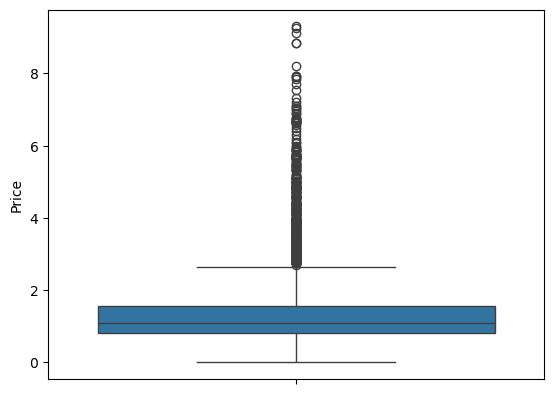

In [37]:
sns.boxplot(data=np.log1p(data['Price']))
plt.show()

In [38]:
data[np.log1p(data.Price) > 2.5].count()

Invoice        9952
StockCode      9952
Description    9952
Quantity       9952
InvoiceDate    9952
Price          9952
Customer ID    9952
Country        9952
dtype: int64

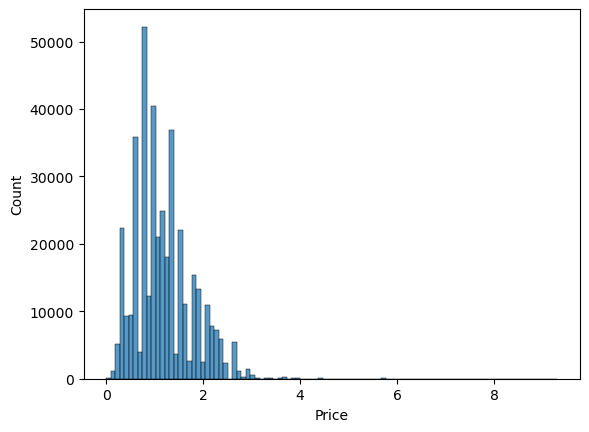

In [39]:
sns.histplot(np.log1p(data['Price']), bins=100)
plt.show()

In [40]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

outliers_price = data[(data['Price'] < lower) | (data['Price'] > upper)]
outliers_price.Price

22         8.50
35         9.95
38         8.95
88         7.95
89        18.00
          ...  
525289     8.50
525290     8.50
525323    12.75
525366     7.95
525396    35.95
Name: Price, Length: 32989, dtype: float64

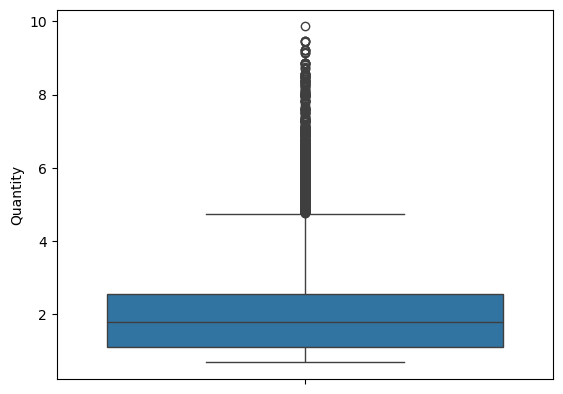

In [41]:
sns.boxplot(data=np.log1p(data['Quantity']))
plt.show()

In [42]:
data[np.log1p(data.Quantity) > 4.5].count()

Invoice        8417
StockCode      8417
Description    8417
Quantity       8417
InvoiceDate    8417
Price          8417
Customer ID    8417
Country        8417
dtype: int64

In [43]:
Q1 = data['Quantity'].quantile(0.25)
Q3 = data['Quantity'].quantile(0.75)
IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

outliers_price = data[(data['Quantity'] < lower) | (data['Quantity'] > upper)]
outliers_price.Quantity

3         48
54        28
55        30
56        30
57        30
          ..
525005    50
525283    72
525285    72
525303    40
525446    48
Name: Quantity, Length: 26338, dtype: int64

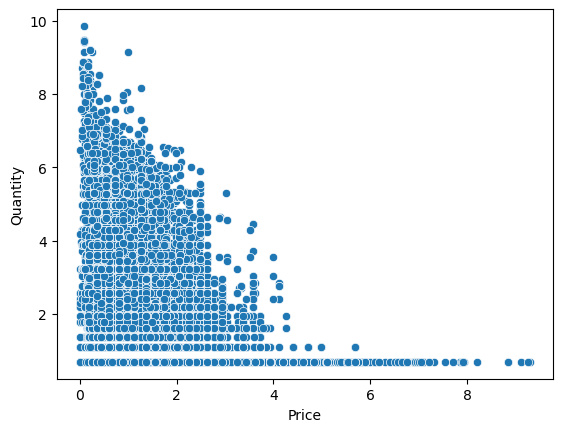

In [44]:
sns.scatterplot(x=np.log1p(data['Price']), y=np.log1p(data['Quantity']))
plt.show()

In [45]:
#удалим наблюдения с Price == 0
zero_price_samples = data[data.Price == 0]

zero_price_samples.agg({'Price': 'count'})

Price    31
dtype: int64

In [46]:
data = data[data.Price != 0.0]
data.shape

(407664, 8)

In [47]:
data[data.Price == 0].agg({'Price': 'count'})

Price    0
dtype: int64

IQR выбросы - важные наблюдения - большие и маленькие клиенты, их удалять нельзя, но можно логарифмировать значения параметров quantity, price, чтобы модель была не так чувствительна к выбросам

In [49]:
data['Price_log'] = np.log1p(data['Price'])
data['Quantity_log'] = np.log1p(data['Quantity'])
data[['Price_log', 'Quantity_log']]

,Price_log,Quantity_log
0,2.073172,2.564949
1,2.047693,2.564949
2,2.047693,2.564949
3,1.131402,3.891820
4,0.810930,3.218876
...,...,...
525456,1.373716,1.098612
525457,1.558145,0.693147
525458,1.558145,0.693147
525459,1.558145,1.098612


Cоздадим целевую переменную - итоговая выручка

In [51]:
data['TotalRevenue'] = data.Price * data.Quantity

Создадим RFM(Recency, Frequency, Monetary) признаки
-
- `Recency`: Количество дней с последней покупки клиента. (max(InvoiceDate) - last_purchase_date)
- `Frequency`: Общее количество чеков (уникальных Invoice) у клиента.
- `Monetary`: Суммарная выручка с клиента (TotalRevenue).

In [53]:
biggest_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('Customer ID')\
          .agg({
              'InvoiceDate': lambda x: (biggest_date - x.max()).days,
              'Invoice': 'nunique',
              'TotalRevenue': 'sum'
              }
          )
rfm.columns = ['recency', 'frequency', 'monetary']

rfm

,recency,frequency,monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93
...,...,...,...
18283.0,18,6,641.77
18284.0,67,1,461.68
18285.0,296,1,427.00


### Признаки поведения:

- `total_products_purchased`: Общее количество купленных товаров.
- `unique_products_count`: Количество уникальных купленных товаров (широта ассортимента).
- `avg_quantity_per_transaction`: Среднее количество товаров в чеке.
- `avg_basket_value`: Средний чек (Monetary / Frequency).


In [55]:
behaviour_features = data.groupby('Customer ID')\
                         .agg(
            total_products_purchased = ('Quantity', 'sum'),
            unique_products_count = ('StockCode', 'nunique'),
            avg_quantity_per_transaction = ('Quantity', 'mean')
        )


behaviour_features['avg_basket_value'] = rfm.monetary / rfm.frequency

behaviour_features

,total_products_purchased,unique_products_count,avg_quantity_per_transaction,avg_basket_value
Customer ID,,,,
12346.0,70,26,2.121212,33.896364
12347.0,828,70,11.661972,661.660000
12348.0,373,20,18.650000,222.160000
12349.0,993,90,9.735294,890.380000
12351.0,261,21,12.428571,300.930000
...,...,...,...,...
18283.0,336,158,1.460870,106.961667
18284.0,494,28,17.642857,461.680000
18285.0,145,12,12.083333,427.000000


In [56]:
trans_details_features = data.groupby('Customer ID')\
                             .agg(
                                 country_diversity = ('Country', 'nunique')
                             )
trans_details_features        

,country_diversity
Customer ID,
12346.0,1
12347.0,1
12348.0,1
12349.0,1
12351.0,1
...,...
18283.0,1
18284.0,1
18285.0,1


Признаки из деталей транзакций:

- `cancellation_rate`: Доля транзакций, которые были отменены.
- `country_diversity`: Количество уникальных стран, в которые клиент делал заказы (если применимо).

In [58]:
trans_details_features = data.groupby('Customer ID')\
                             .agg(
                                 country_diversity = ('Country', 'nunique')
                             )
trans_details_features['cancellation_rate'] = (
    begin_data['Invoice']
    .astype(str)
    .str.startswith('C')
    .groupby(begin_data['Customer ID'])
    .mean()
)

In [59]:
trans_details_features

,country_diversity,cancellation_rate
Customer ID,,
12346.0,1,0.282609
12347.0,1,0.000000
12348.0,1,0.000000
12349.0,1,0.046729
12351.0,1,0.000000
...,...,...
18283.0,1,0.000000
18284.0,1,0.034483
18285.0,1,0.000000


Добавим признаки на основе временных рядов (агрегация по периодам):
Создадим отдельные датасеты с агрегатами за последние 3, 6, 12 месяцев и рассчитаем те же признаки, что и выше, но для этих окон. Это покажет динамику поведения клиента.

- `revenue_last_3m`, `frequency_last_3m`, `avg_basket_last_3m`
- `revenue_growth_3m_vs_6m`: Рост выручки за последние 3 месяца по сравнению с предыдущими 3.

Временные признаки из даты:

- `customer_tenure`: "Возраст" клиента (дни с первой покупки).
- `is_weekend_buyer`: Доля покупок, совершенных на выходных.
- `preferred_hour`: Самый популярный час для покупок.

In [61]:
# Базовая дата для расчета периодов
current_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Признаки за последние 3 месяца
three_months_ago = current_date - pd.DateOffset(months=3)
recent_3m = data[data['InvoiceDate'] >= three_months_ago]

revenue_last_3m = recent_3m.groupby('Customer ID')['TotalRevenue'].sum()
frequency_last_3m = recent_3m.groupby('Customer ID')['Invoice'].nunique()
avg_basket_last_3m = revenue_last_3m / frequency_last_3m

In [62]:
# Признаки за последние 6 месяцев  
six_months_ago = current_date - pd.DateOffset(months=6)
recent_6m = data[data['InvoiceDate'] >= six_months_ago]

revenue_last_6m = recent_6m.groupby('Customer ID')['TotalRevenue'].sum()
revenue_3m_to_6m = revenue_last_6m - revenue_last_3m  # Предыдущие 3 месяца
revenue_growth_3m_vs_6m = (revenue_last_3m - revenue_3m_to_6m) / revenue_3m_to_6m
revenue_growth_3m_vs_6m.replace([np.inf, -np.inf], np.nan, inplace=True)


In [63]:
# customer_tenure
customer_tenure = data.groupby('Customer ID')['InvoiceDate'].agg(lambda x: (x.max() - x.min()).days)

In [64]:
# is_weekend_buyer
data['is_weekend'] = data['InvoiceDate'].dt.dayofweek >= 5
weekend_purchases = data.groupby('Customer ID')['is_weekend'].sum()
total_purchases = data.groupby('Customer ID').size()
is_weekend_buyer = weekend_purchases / total_purchases

In [65]:
# preferred_hour  
data['hour'] = data['InvoiceDate'].dt.hour
preferred_hour = data.groupby('Customer ID')['hour'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean())

Соберем все созданные признаки в один датафрейм, разделим его на X_train, X_test, y_train, y_test по временным промежуткам

In [67]:
#monetary - целевая переменная
customer_features = rfm.copy()

customer_features = customer_features.join(behaviour_features, how='left')\
                                     .join(trans_details_features, how='left')

customer_features['revenue_last_3m'] = revenue_last_3m
customer_features['frequency_last_3m'] = frequency_last_3m
customer_features['avg_basket_last_3m'] = avg_basket_last_3m

customer_features['revenue_last_6m'] = revenue_last_6m
customer_features['revenue_3m_to_6m'] = revenue_3m_to_6m
customer_features['revenue_growth_3m_vs_6m'] = revenue_growth_3m_vs_6m

customer_features['customer_tenure'] = customer_tenure
customer_features['is_weekend_buyer'] = is_weekend_buyer
customer_features['preferred_hour'] = preferred_hour

customer_features.rename(columns={'monetary': 'TotalRevenue'}, inplace=True)

customer_features.head()

,recency,frequency,TotalRevenue,total_products_purchased,unique_products_count,avg_quantity_per_transaction,avg_basket_value,country_diversity,cancellation_rate,revenue_last_3m,frequency_last_3m,avg_basket_last_3m,revenue_last_6m,revenue_3m_to_6m,revenue_growth_3m_vs_6m,customer_tenure,is_weekend_buyer,preferred_hour
Customer ID,,,,,,,,,,,,,,,,,,
12346.0,165,11,372.86,70,26,2.121212,33.896364,1,0.282609,NaN,NaN,NaN,142.31,NaN,NaN,196,0.00000,13
12347.0,3,2,1323.32,828,70,11.661972,661.660000,1,0.000000,1323.32,2.0,661.66,1323.32,0.0,NaN,37,0.56338,14
12348.0,74,1,222.16,373,20,18.650000,222.160000,1,0.000000,222.16,1.0,222.16,222.16,0.0,NaN,0,0.00000,14
12349.0,43,3,2671.14,993,90,9.735294,890.380000,1,0.046729,1402.62,1.0,1402.62,1402.62,0.0,NaN,181,0.00000,8
12351.0,11,1,300.93,261,21,12.428571,300.930000,1,0.000000,300.93,1.0,300.93,300.93,0.0,NaN,0,0.00000,15


In [68]:
customer_features.isnull().sum()

recency                            0
frequency                          0
TotalRevenue                       0
total_products_purchased           0
unique_products_count              0
avg_quantity_per_transaction       0
avg_basket_value                   0
country_diversity                  0
cancellation_rate                  0
revenue_last_3m                 1435
frequency_last_3m               1435
avg_basket_last_3m              1435
revenue_last_6m                  814
revenue_3m_to_6m                1435
revenue_growth_3m_vs_6m         3007
customer_tenure                    0
is_weekend_buyer                   0
preferred_hour                     0
dtype: int64

In [69]:
#заменяем nan нулями, поскольку они означают отсутствие метрики у клиента
customer_features = customer_features.fillna(0)

Разделим выборку на train/test по временным промежуткам

Train — клиенты, завершившие покупки до 2010-11-20

Test — клиенты, покупавшие в 2010-11-20

In [71]:
last_purchase_date = data.groupby('Customer ID')['InvoiceDate'].max()

customer_features['last_purchase_date'] = last_purchase_date

X = customer_features.drop(columns=['TotalRevenue', 'last_purchase_date'])
y = customer_features['TotalRevenue']

train_customers = customer_features[customer_features['last_purchase_date'] < '2010-11-20']
test_customers  = customer_features[customer_features['last_purchase_date'] >= '2010-11-20']

X_train = train_customers.drop(columns=['TotalRevenue', 'last_purchase_date'])
y_train = train_customers['TotalRevenue']

X_test = test_customers.drop(columns=['TotalRevenue', 'last_purchase_date'])
y_test = test_customers['TotalRevenue']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3169, 17) (3169,) (1143, 17) (1143,)


Масштабируем признаки сначала robust, потом - standard скейлерами, чтобы минимизировать влияние выбросов на масштаб

In [73]:
robust = RobustScaler()

X_train_robust = robust.fit_transform(X_train)
X_test_robust = robust.transform(X_test)

standard = StandardScaler()

X_train_scaled = standard.fit_transform(X_train_robust)
X_test_scaled = standard.transform(X_test_robust)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [74]:
#изучим корреляцию переменных
corr_matrix = customer_features.drop('last_purchase_date', axis=1).corr()
corr_matrix[lambda x: abs(x) > 0.8]

,recency,frequency,TotalRevenue,total_products_purchased,unique_products_count,avg_quantity_per_transaction,avg_basket_value,country_diversity,cancellation_rate,revenue_last_3m,frequency_last_3m,avg_basket_last_3m,revenue_last_6m,revenue_3m_to_6m,revenue_growth_3m_vs_6m,customer_tenure,is_weekend_buyer,preferred_hour
recency,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frequency,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.874627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalRevenue,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.900410,NaN,NaN,0.969945,0.951939,NaN,NaN,NaN,NaN
total_products_purchased,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_products_count,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_quantity_per_transaction,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_basket_value,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_diversity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cancellation_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue_last_3m,NaN,NaN,0.900410,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.960463,0.815483,NaN,NaN,NaN,NaN


Исходя из таблицы выше, видим, что признаки, отображающие одинаковые метрики, но, например, в разные периоды (frequency, frequency_last_3m) имеют большую положительную корреляцию, что очевидно. Исходя из этого, проблем с мультиколлинеарностью мы не испытаем

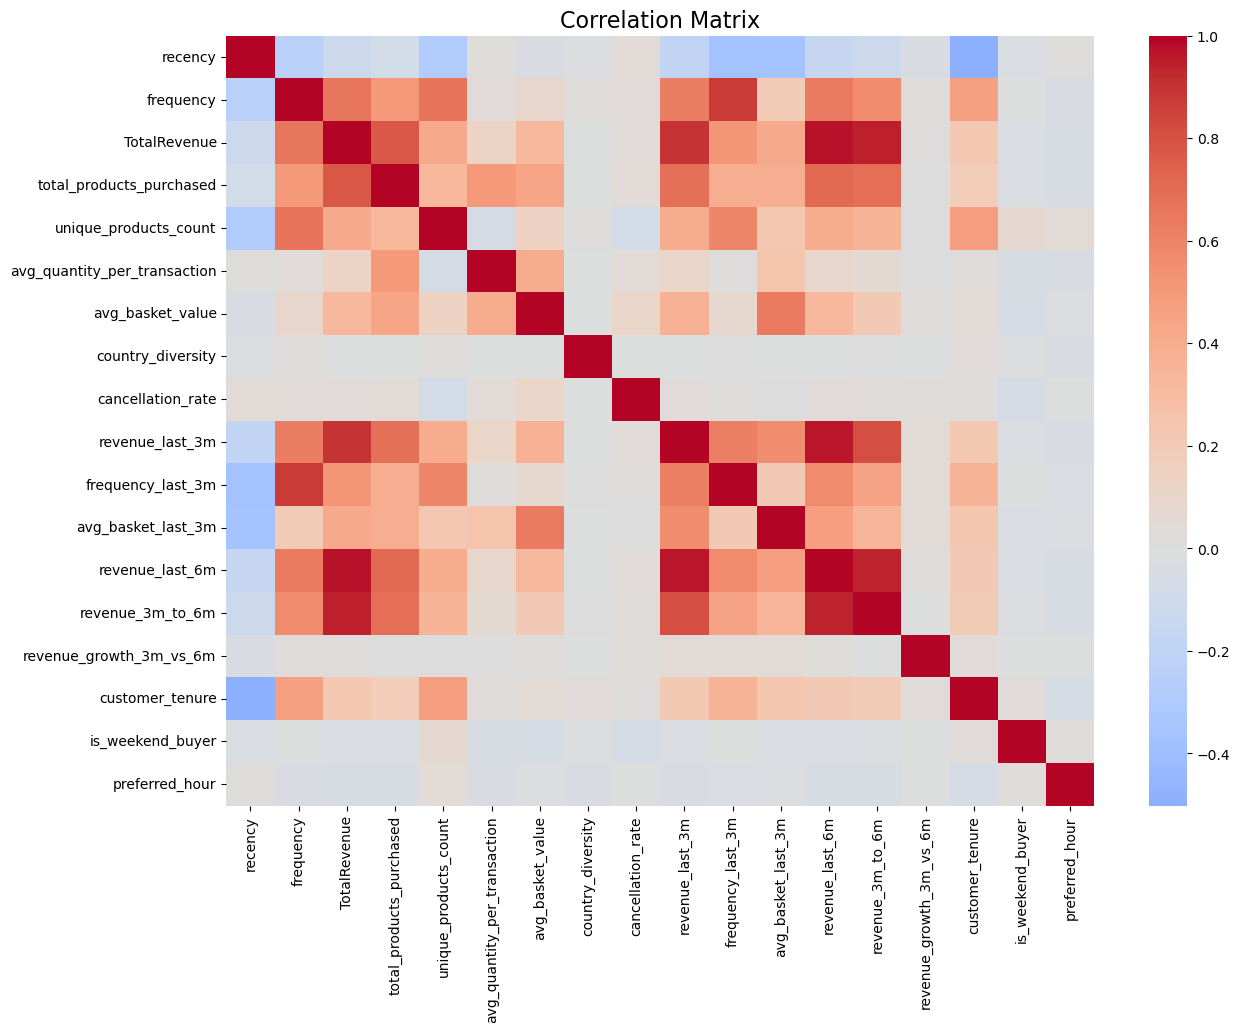

In [76]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

Skewness: 23.970122269906483; Kurtosis: 755.1142144366942


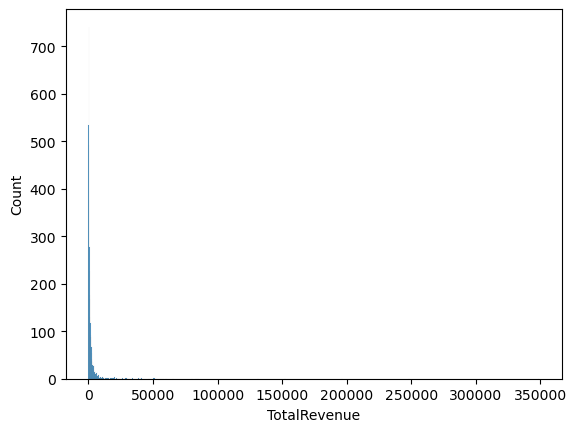

In [77]:
#Изучим распределение целевого признака
print(f'Skewness: {skew(customer_features.TotalRevenue)}; Kurtosis: {kurtosis(customer_features.TotalRevenue)}')

sns.histplot(data=customer_features.TotalRevenue)
plt.show()

In [78]:
customer_features.TotalRevenue.describe()

count      4312.000000
mean       2048.238236
std        8914.481280
min           2.950000
25%         307.987500
50%         706.020000
75%        1723.142500
max      349164.350000
Name: TotalRevenue, dtype: float64

### Что говорят метрики распределения
- `Skewness = 23.97` → экстремально сильная правосторонняя асимметрия
- `Kurtosis = 755` → гигантская "тяжёлохвостость" распределения
- `Максимум 349 164 при медиане 706` → огромные выбросы
- `Std >> mean` → данные крайне нестабильны

Исходя из этого, логарифмируем целевую переменную

In [80]:
y_train_scaled = np.log1p(y_train)
y_test_scaled = np.log1p(y_test)


Skewness: 0.08886234355137716; Kurtosis: 0.2618433858447844


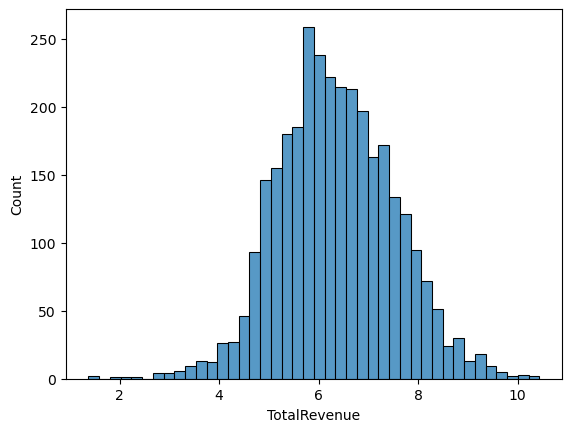

In [81]:
print(f'Skewness: {skew(y_train_scaled)}; Kurtosis: {kurtosis(y_train_scaled)}')

sns.histplot(data=y_train_scaled)
plt.show()

In [82]:
#Baseline
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train_scaled, y_train_scaled)

y_pred_dummy_logged = dummy_regr.predict(X_test_scaled)
y_pred_dummy = np.expm1(y_pred_dummy_logged)

mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)
mape_dummy = np.mean(np.abs((y_test - y_pred_dummy) / y_test)) * 100

print(f"MAE: {mae_dummy:.2f}")
print(f"RMSE: {rmse_dummy:.2f}") 
print(f"MAPE: {mape_dummy:.2f}%")
print(f"R²: {r2_dummy:.2f}")

MAE: 4058.33
RMSE: 17193.62
MAPE: 89.69%
R²: -0.06


In [83]:
#simple ridge, lasso
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

for name, model in models.items():
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train_scaled)
    
    y_pred = np.expm1(grid.predict(X_test_scaled))
    
    print(f"{name} Results:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"MAPE: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%")
    print(f"R²: {r2_score(y_test, y_pred):.2f}\n")

Lasso Results:
MAE: 719058723402996224.00
RMSE: 24098162167450288128.00
MAPE: 208270431522518.81%
R²: -2073978597413942853997273546752.00

Ridge Results:
MAE: 14848814205823346.00
RMSE: 402312168550655360.00
MAPE: 5537292707804.38%
R²: -578046482062489280172785664.00



In [84]:
#Исходя из того, что мы имеем дело с временными рядами, в качестве cv используем timeseriessplit
tscv = TimeSeriesSplit(n_splits=5)

#randomforestregressor
rf_regr = RandomForestRegressor()
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

rf_regr_grid = RandomizedSearchCV(rf_regr, param_distributions=rf_params, n_iter=50, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
rf_regr_grid.fit(X_train_scaled, y_train_scaled)
best_rf = rf_regr_grid.best_estimator_
y_pred_rf_logged = best_rf.predict(X_test_scaled)
y_pred_rf = np.expm1(y_pred_rf_logged)

print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100:.2f}%")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}\n")

MAE: 1908.65
RMSE: 14934.50
MAPE: 11.41%
R²: 0.20



In [85]:
#XGBoost
xgb_params = {
    'n_estimators': [300, 500, 800, 1200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    scoring='neg_mean_absolute_error',
    n_iter=30,
    cv=tscv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

xgb_random.fit(X_train_scaled, y_train_scaled)
print("Best params:", xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_

y_pred_xgb_logged = best_xgb.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_xgb_logged)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [86]:
print(f"MAE:, {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"MAPE: {np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100:.2f}%")
print(f"R2: {r2_score(y_test, y_pred_xgb):.2f}")

MAE:, 1566.72
RMSE: 13770.88
MAPE: 6.34%
R2: 0.32


- MAPE = 11.5%
  
Это неплохой показатель для задач предсказания выручки, особенно если много выбросов.
- RMSE слишком большой
  
RMSE = 13k означает, что большие ошибки сильны, на дальних хвостах модель ошибается кратно.
- R² = 0.32 — низкий
  
Модель объясняет только 32% вариации revenue.
Для деревьев и бустингов в e-commerce обычно R² = 0.55–0.75.
Поэтому итог: качество слабое, особенно RMSE и R².

In [88]:
X_train_scaled.columns

Index(['recency', 'frequency', 'total_products_purchased',
       'unique_products_count', 'avg_quantity_per_transaction',
       'avg_basket_value', 'country_diversity', 'cancellation_rate',
       'revenue_last_3m', 'frequency_last_3m', 'avg_basket_last_3m',
       'revenue_last_6m', 'revenue_3m_to_6m', 'revenue_growth_3m_vs_6m',
       'customer_tenure', 'is_weekend_buyer', 'preferred_hour'],
      dtype='object')

In [89]:
#Улучшить таргет-трансформацию

# 1) log1p
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2) RobustScaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()

y_train_scaled = rs.fit_transform(y_train_log.values.reshape(-1, 1))
y_test_scaled = rs.transform(y_test_log.values.reshape(-1, 1))

# 3) PowerTransformer (Yeo–Johnson)
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

y_train_trans = pt.fit_transform(y_train_scaled)
y_test_trans = pt.transform(y_test_scaled)

In [90]:
#Борьба с мультиколлинеарностью
cols_to_drop = ['frequency_last_3m',
                'revenue_last_3m',
                'revenue_last_6m',
                'revenue_3m_to_6m']

X_train_scaled_upd = X_train_scaled.drop(columns=cols_to_drop)

X_test_scaled_upd = X_test_scaled.drop(columns=cols_to_drop)

CatBoostRegressor обычно выигрывает XGBoost на табличных данных с малым количеством строк и большим количеством зависимых признаков, поэтому было принято решение обучать CatBoost.

In [92]:
cat_regr = CatBoostRegressor(
    iterations=1500,
    depth=8,
    learning_rate=0.03,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

cat_regr.fit(X_train_scaled_upd, y_train_trans.ravel())
y_pred_trans = cat_regr.predict(X_test_scaled_upd)

# 1) undo PowerTransformer
y_pred_scaled = pt.inverse_transform(y_pred_trans.reshape(-1, 1))

# 2) undo RobustScaler
y_pred_log = rs.inverse_transform(y_pred_scaled)

# 3) undo log1p
y_pred = np.expm1(y_pred_log).ravel()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [93]:
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("MAPE (%):", mape)

MAE: 1694.9195160328097
RMSE: 15024.065957395207
R²: 0.1938582975916131
MAPE (%): 5.122043579842463


Метрики стали еще хуже, поэтому делаю вывод, что скейл через PowerTransformer и Robust ни к чему, поскольку СatBoost хорошо справляется с не масштабированными значениями (однако логарифмирование сохраняю). Ниже - baseline и потом уже итоговый CatBoost

In [95]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

X_train_cb = X_train.drop(columns=cols_to_drop)
X_test_cb = X_test.drop(columns=cols_to_drop)

In [96]:
cat_base = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1500,
    depth=8,
    learning_rate=0.03,
    random_seed=42,
    verbose=False
)

cat_base.fit(X_train_cb, y_train_log)

y_pred_log = cat_base.predict(X_test_cb)
y_pred = np.expm1(y_pred_log)

In [97]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
print("MAPE (%):", mape)

MAE: 1684.0124157747366
RMSE: 15024.47552437126
R²: 0.19381434497311611
MAPE (%): 5.12233084406883


In [194]:
cat_model = CatBoostRegressor(
    iterations=2000,
    depth=8,
    learning_rate=0.03,
    loss_function='MAE',
    random_seed=42,
    verbose=False
)

params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [1000, 1500, 2000]
}


grid = GridSearchCV(
    estimator=cat_model,
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

grid.fit(X_train_cb, y_train_log)

# Лучшая модель
best_cat = grid.best_estimator_
print("Лучшие параметры:", grid.best_params_)

best_cat.fit(X_train_cb, y_train_log)

y_pred_log_best = best_cat.predict(X_test_cb)
y_pred_best = np.expm1(y_pred_log_best)

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)
# Обход y_test или y_pred_best содержащих NaN или inf
mask = (y_test != 0) & np.isfinite(y_test) & np.isfinite(y_pred_best)
mape = np.mean(np.abs((y_test[mask] - y_pred_best[mask]) / y_test[mask])) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE (%): {mape}")

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'depth': 4, 'iterations': 2000, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
MAE: 1412.7255287966916
RMSE: 13536.152549443745
R²: 0.3456246891079806
MAPE (%): 4.126912423376421


Меня более чем устраивают такие метрики, поэтому далее - изучение итоговый версии модели, ее ошибок и важности фичей

In [196]:
feat_imp = pd.DataFrame({
    'feature': X_train_cb.columns,
    'importance': best_cat.get_feature_importance()
}).sort_values('importance', ascending=False)

feat_imp

,feature,importance
5,avg_basket_value,40.495501
1,frequency,28.413388
2,total_products_purchased,17.930370
10,customer_tenure,8.708277
8,avg_basket_last_3m,1.752316
3,unique_products_count,1.560686
4,avg_quantity_per_transaction,0.487118
7,cancellation_rate,0.203891
0,recency,0.166354
9,revenue_growth_3m_vs_6m,0.120704


<Figure size 1000x600 with 0 Axes>

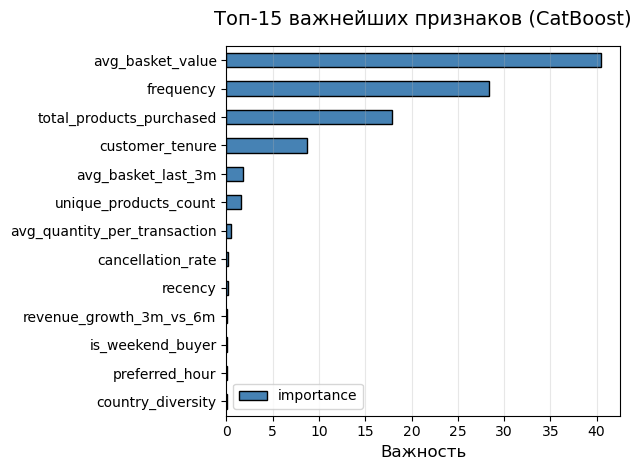

In [197]:
# Feature importance график с сортировкой по данным
plt.figure(figsize=(10, 6))
feat_imp.sort_values('importance', ascending=True).tail(15).plot.barh(
    x='feature', 
    y='importance',
    color='steelblue',
    edgecolor='black'
)
plt.title('Топ-15 важнейших признаков (CatBoost)', fontsize=14, pad=15)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


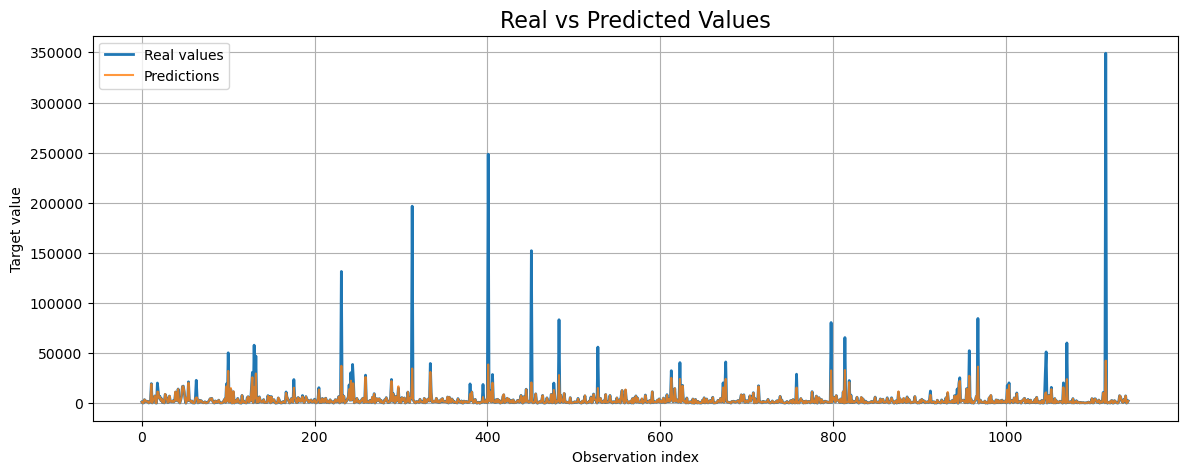

In [198]:
#prediction vs real values
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Real values', linewidth=2)
plt.plot(y_pred_best, label='Predictions', alpha=0.8)
plt.title("Real vs Predicted Values", fontsize=16)
plt.xlabel("Observation index")
plt.ylabel("Target value")
plt.legend()
plt.grid(True)
plt.show()


На графике видно, что в некоторых местах (выбросах вверх), модель сильно ошибается

Подробнее изучим крупные ошибки модели

In [200]:
errors = abs(y_test - y_pred_best)
top_10_worst = errors.nlargest(10)
print("Клиенты с наибольшей ошибкой прогноза:")
print(top_10_worst)

errors[errors > 5000].count()

Клиенты с наибольшей ошибкой прогноза:
Customer ID
18102.0    306697.290052
14646.0    209768.483708
14156.0    161896.438192
14911.0    131405.387181
13694.0     94120.607692
15061.0     55210.075407
17511.0     48040.217874
16684.0     47720.299759
13089.0     42227.091180
15311.0     40827.760879
Name: TotalRevenue, dtype: float64


32

Таким образом можно удостовериться в том, что модель действительно иногда делает крупные ошибки, однако учитывая их малое количество и то, что они такие ошибки происходят в местах статистических выбросов, можно заявить об их статистической незначимости

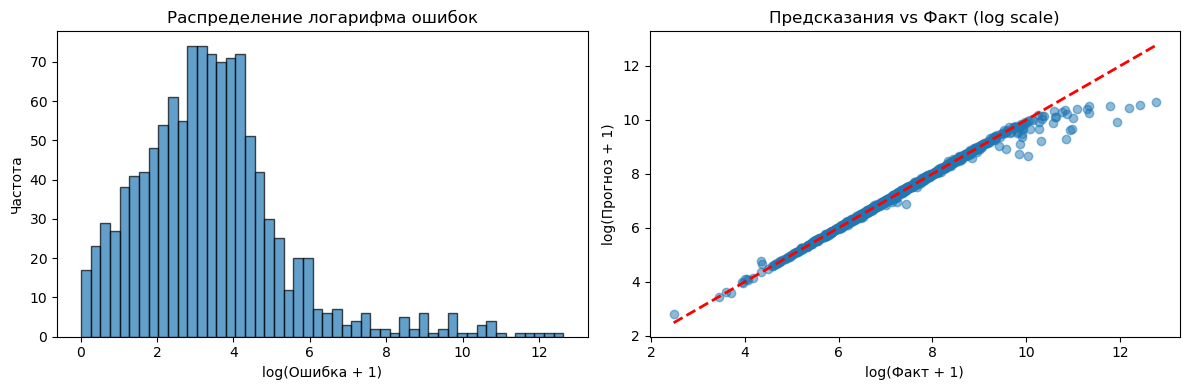

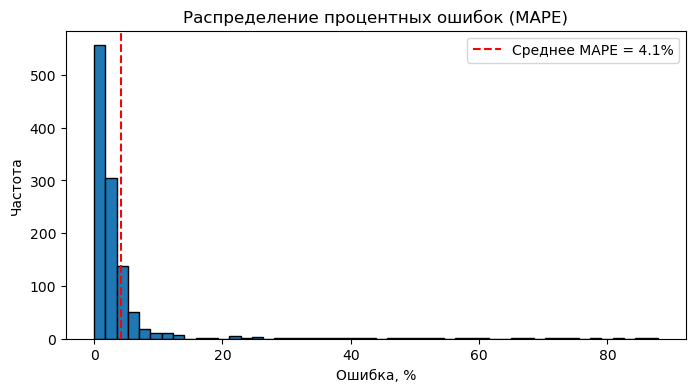

In [202]:
# 1. Логарифмировать ошибки для лучшей визуализации
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
log_errors = np.log1p(errors)  # или np.log(errors + 1)
plt.hist(log_errors, bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение логарифма ошибок')
plt.xlabel('log(Ошибка + 1)')
plt.ylabel('Частота')

# 2. Scatter plot на логарифмированной шкале
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(y_test), np.log1p(y_pred_best), alpha=0.5)
x_range = [np.log1p(y_test).min(), np.log1p(y_test).max()]
plt.plot(x_range, x_range, 'r--', lw=2)
plt.title('Предсказания vs Факт (log scale)')
plt.xlabel('log(Факт + 1)')
plt.ylabel('log(Прогноз + 1)')

plt.tight_layout()
plt.show()

# 3. Процент ошибок вместо абсолютных
percent_errors = (errors / y_test) * 100
plt.figure(figsize=(8, 4))
plt.hist(percent_errors.clip(0, 200), bins=50, edgecolor='black')  # обрезаем на 200%
plt.title('Распределение процентных ошибок (MAPE)')
plt.xlabel('Ошибка, %')
plt.ylabel('Частота')
plt.axvline(mape, color='red', linestyle='--', label=f'Среднее MAPE = {mape:.1f}%')
plt.legend()
plt.show()

## Итоги проекта

### Что удалось сделать

Мы построили модель для прогнозирования выручки B2B-клиентов. Основные метрики:

- **Средняя ошибка** — 1 413 на клиента
- **Относительная ошибка** — всего 4.1%, что является хорошим результатом для бизнес-прогнозов
- **Объясняющая способность** — модель учитывает около 35% факторов, влияющих на выручку

### Что важно понимать о модели

**Сильные стороны:**
1. Модель даёт достаточно точные прогнозы в среднем — ошибка в 4% допустима для многих бизнес-задач
2. Логика модели прозрачна: самые важные факторы — это средний чек, частота покупок и их объём
3. Простые бизнес-метрики оказались эффективнее сложных конструкций

**Ограничения:**
1. Модель работает лучше на массовом сегменте, чем на отдельных клиентах
2. Есть клиенты с большими отклонениями — в основном это либо очень крупные, либо нерегулярные заказчики
3. Мы пока не учитываем сезонность и изменения в поведении клиентов со временем

### Практическая ценность

Эту модель можно использовать для:
- Планирования ожидаемой выручки в разрезе клиентских сегментов
- Выявления клиентов с потенциально высокой выручкой
- Понимания ключевых драйверов роста выручки

Требуется осторожность при:
- Прогнозировании для конкретного крупного клиента
- Принятии решений на основе индивидуальных прогнозов

### Что можно улучшить в будущем

Если продолжать развитие проекта, стоит:
1. Добавить данные о договорах и условиях работы с клиентами
2. Учесть сезонные и временные паттерны
3. Разделить клиентов на группы и строить отдельные модели для каждого сегмента

### В заключение

Мы создали работоспособную модель, которая даёт разумные прогнозы. Она не идеальна, но уже сейчас может приносить практическую пользу. Главное — понимать её границы применения и постепенно устранять ограничения.